In [51]:
import glob as glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold

Read the smiles input file

In [52]:
with open('chembl_33_np.smi', 'r') as f:
    smiles = np.array(f.readlines())

Generate the fingerprints with RDKit, if fingerprints are already generated, skip this step

In [ ]:
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
fps = np.array([Chem.RDKFingerprint(mol) for mol in mols])    

Check the data type

In [54]:
print(f'Bits are binary: {np.all(np.isin(fps, [0, 1]))}')
print(f'Data type is int64: {fps.dtype == np.int64 or fps.dtype == np.float64}')

Bits are binary: True
Data type is int64: True


Check the data size

In [55]:
print(f'Number of fingerprints: {fps.shape[0]}')
print(f'Number of bits: {fps.shape[1]}')
print(f'Number of fingerprints mathces the number of smiles: {fps.shape[0] == len(smiles)}')

Number of fingerprints: 64086
Number of bits: 2048
Number of fingerprints mathces the number of smiles: True


In [6]:
# Delete the mols to save memory
del mols

Now we are going to split our fingerprints in 10 batches and then recluster. We recommend saving the fingerprints in separate files or generating them in batches as we pass them. It all depends in the available disk and memory available

In [56]:
n_splits = 5
fps_splits = np.array_split(fps, n_splits)
index_splits = np.array_split(np.arange(len(fps)), n_splits)

os.makedirs('fps', exist_ok=True)

with open('fps_splits.txt', 'w') as f:
    for i, (index_split, fps_split) in enumerate(zip(index_splits, fps_splits)):
        initial_index = index_split[0]
        final_index = index_split[-1]
        f.write(f'{initial_index}_{final_index}\n')
        np.save(f'fps/fps_{initial_index}_{final_index}.npy', fps_split)

Now we are going to do the clustering of each split, for this we attach .sh examples that will run the jobs to cluster each of the splits. The use of parallelization with subprocess module is possible, but it is not as fast. 

The jobs can we execute in the next cell, but is much faster to do it directly from the command line doing `./sub.sh` or `./sub_slurm.sh` in case of access to a cluster/supercomputer. Please modify you .sh file to match the requirements of your clusters, the attached files are just examples.

In [ ]:
os.system('./sub_parallel.sh')

0

Now we proceed to cluster the generated centroids.
This will generated two files, clustered_ids_parallel.pkl (which contains the clustered ids of the molecules) and final_centroids_parallel.pkl (which contains the fingerprints of the final centroids for further analysis if needed).

If wanted, the threshold can be changed by the user. We recommend a higher threshold than the former, because we are not clustering the molecules directly.

You only have to run `python birch_BFs.py -t 0.675` on your command line.

Depending on the size of your set, you would have to run this on command line or submit a job to a cluster/supercomputer. Again, as example .sh file are provided, please modify to your necessity. 

Notice that for the final clustering we increase a little bit the clustering.

In [61]:
os.system('./sub_final_clustering.sh')

0

### Now let's take a look at the results

In [10]:
# Read .npy files and put them in a list
fps = []
for file in glob.glob('fps/*.npy'):
    fps.extend(np.load(file))

fps = np.array(fps)

In [62]:
# Read the clustered_ids_parallel.pkl file
with open('clustered_ids_parallel.pkl', 'rb') as f:
    clustered_ids = pickle.load(f)

# Sort clustered_ids by the number of elements in each cluster
clustered_ids = sorted(clustered_ids, key=len, reverse=True)

In [63]:
def population_plot(clustered_ids, smiles, top_clusters=20):
    # Sort BFs by size
    clustered_ids = sorted(clustered_ids, key=lambda x: len(x), reverse=True)

    # Get the BFs of interest
    mol_indices = clustered_ids[:top_clusters]

    # Plot the population
    plt.figure(figsize=(10, 10))
    plt.bar(range(top_clusters), [len(x) for x in mol_indices], color = 'blue', label='Population')

    # Anotate the number of molecules in each cluster above the bars
    for i, mol in enumerate(mol_indices):
        plt.text(i, len(mol), len(mol), ha='center', va='bottom')

    # Get the number of unique scaffolds in each cluster
    unique_scaffolds = []
    for cluster_of_interest in mol_indices:
        # Get the smiles in the cluster of interest
        smiles_interest = [smiles[i] for i in cluster_of_interest]

        # Get the Scaffols of the molecules in the cluster of interest
        scaffolds = [MurckoScaffold.MurckoScaffoldSmilesFromSmiles(smile) for smile in smiles_interest]

        # Get the unique scaffolds
        unique_scaffolds.append(len(list(set(scaffolds))))
    
    # Plot the number of unique scaffolds in each cluster
    plt.bar(range(top_clusters), unique_scaffolds, color = 'orange', label='Unique Scaffolds')

    # Anotate the number of unique scaffolds in each cluster above the bars
    for i, mol in enumerate(unique_scaffolds):
        plt.text(i, mol, mol, ha='center', va='bottom', color='white')

        plt.xticks(range(top_clusters), rotation=45)

    plt.show()

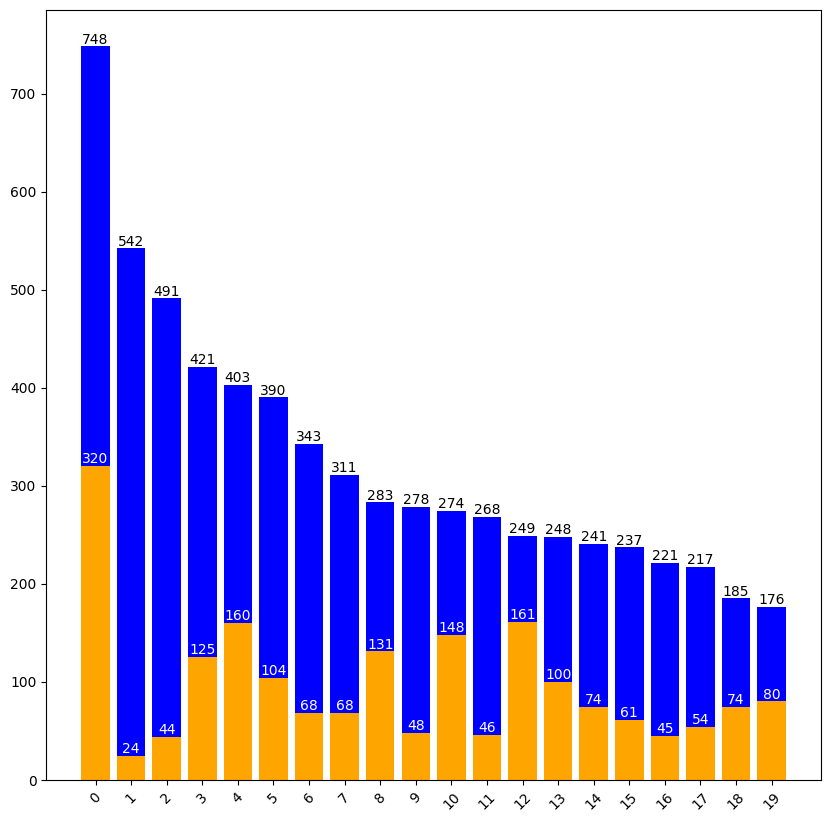

In [67]:
population_plot(clustered_ids, smiles, top_clusters=20)

You can notice that the quality of some clusters might not be the best, but it is on par with Taylor-Butina. A way of getting better clusters with BitBIRCH is coming up... Follow the MQ-lab for more updates

Generate images of the molecules in a particular cluster

In [ ]:
label = 0
mols = [Chem.MolFromSmiles(smiles[i]) for i in clustered_ids[label]]
print('Number of molecules:', len(mols))

for i in range(0, len(mols), 30):

    img_1 = Draw.MolsToGridImage(mols[i:i+30], molsPerRow=5)

    # Save the images from the .data attribute
    with open(f'cluster_{label}_{i}.png', 'wb') as f:
        f.write(img_1.data)

Number of molecules: 748


Get number of clusters

In [69]:
print(f'Number of clusters: {len(clustered_ids)}')
print(f'number of clusters with more than 10 molecules: {len([cluster for cluster in clustered_ids if len(cluster) > 10])}')

Number of clusters: 15249
number of clusters with more than 10 molecules: 1011
